The CDR equation
$$
  \partial_t u -  \varepsilon \Delta u +\boldsymbol{b}\cdot\nabla u+ c u = f \quad \text{in} \quad (0,T)\times \Omega \\
  u = 0 \quad \text{on}\quad \partial \Omega \\
  u(0,\cdot) = u_0 \quad \text{on} \quad \Omega
$$
Introduce $\boldsymbol{ \sigma} = -\varepsilon \nabla u$, the problem can be rewritten as:
\begin{align*}
  \partial_t u +  \nabla \cdot \boldsymbol{\sigma}-\boldsymbol{\beta}\boldsymbol{\sigma} + c u &= f \quad \text{in} \quad (0,T)\times \Omega \\
  u &= 0 \quad \text{on}\quad \partial \Omega \\
  u(0,\cdot) &= u_0 \quad \text{on} \quad \Omega
\end{align*}
and 
$$
\varepsilon^{-1} \sigma + \nabla u = 0
$$
Introducing the spaces $V=L^2(\Omega)$ and $\boldsymbol{W}=H(div; \Omega)$. Then, the mixed formulation becomes

$$
(\partial_t u,v) +  (\nabla \cdot \boldsymbol{\sigma},v)-(\boldsymbol{\beta}\boldsymbol{\sigma},v) + (c u,v) = (f,v) \quad \forall v\in V \\
(\varepsilon^{-1} \sigma, \boldsymbol{w}) - (u, \nabla \cdot \boldsymbol{w}) = 0 \quad \forall \boldsymbol{w}\in \boldsymbol{W}
$$

σ = ϵ ∇ u
u_t + ∇⋅σ + β ⋅ σ + γ u = f

(u_t,v) + (∇⋅σ, v) + (β ⋅ σ, v) + γ(u,v)= (f,v)
ϵ^-1 (σ,τ) + (u, ∇⋅τ) = 0 ###  ∫_Γ u τ ⋅ n


In [5]:
module ExampleMixedFEMTCDR
using GradientRobustMultiPhysics
using ExtendableGrids
using GridVisualize
using ExtendableSparse
using Printf

"""
    get_problem_data(ν)

TBW
"""
function get_problem_data(ϵ)
    γ= DataFunction([1.0]; name = "γ")
    β = DataFunction([1.0,2.0]; name = "β")    
    function exact!(result, x, t)
        result[1] = x[1]*t^4 + x[2] # x[1]*(1-x[1])*x[2]*(x[2]-1)*t# 1 + x[1]^2 + x[2]^2 + 1.2*t^3
     end
    
    u = DataFunction(exact!, [1,2]; name="u", dependencies="XT", bonus_quadorder=5)
    dt_u = eval_dt(u)
    ∇u = eval_∇(u)
    Δu = eval_Δ(u)
    function rhs!(result, x, t)    
        # dt_u = 1.2*3*t^2
        result[1] = dt_u(x,t)[1]-ϵ*Δu(x,t)[1] + dot(β(), ∇u(x,t))[1] + dot(γ(), u(x,t)[1]) # α * u(x,t)[1]
      return nothing
    end
    f = DataFunction(rhs!, [1,2]; name = "f", dependencies = "XT", bonus_quadorder = 5)
    return γ, β, u, ∇(u), f
  end

"""
    main(; scheme = 1, ϵ = 1, verbosity = 0, nlevels=2, T0 = 0, Tf=1, nsteps=10)

TBW
"""
function main(; scheme = 1, ϵ = 1, verbosity = 0, nlevels=2, T0 = 0, Tf=1, nsteps=10)
  ## set log level
  set_verbosity(verbosity)
  ## load initial mesh
  xgrid = grid_unitsquare(Triangle2D)
  # choose a finite element type

  FEType = [H1P1{1}, HDIVRT1{2}]
  #TODO: fix from the problem data
  u0 = DataFunction([0.0])
    
  ## negotiate data functions to the package
  γ, β, u, ∇u, f = get_problem_data(ϵ)

  function convection_kernel(result, input)
    # evaluate β
    eval_data!(β)
    # compute β ⋅ \sigma
        result[1] = 0.0
        for k = 1 : 2
            result[1] += β.val[k]*input[k]
        end
  end
  action = Action(convection_kernel, [1, 2]; dependencies = "", bonus_quadorder = β.bonus_quadorder) 
  CO = BilinearForm([Identity, Identity], action; factor = -1, transposed_assembly = true)

    
  for level = 1 : nlevels
    # refine the grid 
    xgrid = uniform_refine(xgrid)
  end
  FES = [FESpace{FEType[1]}(xgrid; broken = true), FESpace{FEType[2]}(xgrid)]
  # @show FES
  Solution = FEVector(FES)
  n_dofs = FES[1].ndofs
  interpolate!(Solution[1], u; time = 0.0)
  Solnm1 = FEVector(FES)
  interpolate!(Solnm1[1], u; time = 0.0)
  Solnm2 = FEVector(FES)
  interpolate!(Solnm2[1], u; time = 1e-9)
  

  M = FEMatrix(FES)
  assemble_operator!(M[1,1], BilinearForm([Identity, Identity]))
  # @show M.entries
  # println(size(M[1,1]))
  #println("ndofs: ", FES[1].ndofs)
  A = FEMatrix(FES)
  assemble_operator!(A[1,2], CO; time=0.0)
  assemble_operator!(A[1,1], ReactionOperator(γ); time=0.0)
  assemble_operator!(A[2,1], LagrangeMultiplier(Divergence); At = A[1,2]) 
  assemble_operator!(A[2,2], BilinearForm([Identity, Identity]; factor = 1/ϵ))
  # @show A.entries

  rhs = FEVector(FES)
  assemble_operator!(rhs[1], LinearForm(Identity, f); time=0.0)
  assemble_operator!(rhs[2], LinearForm(NormalFlux, u; AT=ON_BFACES); time=0.0)
  # @show rhs.entries

  t0 = T0
  tau = (Tf - T0)/nsteps
  @show nlevels, nsteps
    
  V1 = zeros(Float64, FES[1].ndofs+FES[2].ndofs, 1)
  #V1 = FEVector(FES)
  Mu0 = zeros(Float64, FES[1].ndofs)    

  SystemMatrix = FEMatrix(FES)
  # @show SystemMatrix
  SystemRHS = FEVector(FES)
  SystemSol = FEVector(FES)
  
  step = one(Int)

  l2max = -one(Float64)
  first_step  = true
# --------------------------Time step start -----------------------------------------------------------
  nts = 1
  oldL2 = zero(Float64); oldh1 = zero(Float64)
  eL2 = zero(Float64); eh1 = zero(Float64)
  while t0 <= Tf-1e-10
    t0 = t0 + tau
    fill!(SystemRHS.entries, 0)
    fill!(rhs.entries, 0)
    assemble_operator!(rhs[1], LinearForm(Identity, f); time=t0)
    assemble_operator!(rhs[2], LinearForm(NormalFlux, u; AT=ON_BFACES, factor = -1); time=t0)
    V1[:, 1] = rhs.entries
    #addblock!(SystemRHS[1], M.entries*Solution[1].entries; factor= 1.0/tau)

    fill!(SystemMatrix.entries.cscmatrix.nzval, 0)
    fill!(A.entries.cscmatrix.nzval, 0)
    # assembling the matrices with coefficients depending on time 
    assemble_operator!(A[1,2], CO; time=t0)
    assemble_operator!(A[1,1], ReactionOperator(γ); time=t0)
    assemble_operator!(A[2,1], LagrangeMultiplier(Divergence); At = A[1,2]) 
    assemble_operator!(A[2,2], BilinearForm([Identity, Identity]; factor = 1/ϵ))
    if nts == 1
      if scheme == 2
        @info("First step with BDF1")
      end      
      #first step by bdf1
      addblock!(SystemRHS[1], M.entries*Solution[1].entries; factor= 1.0/tau)
      addblock!(SystemRHS[1], V1[:,1]; factor= 1.0 )
    
      addblock!(SystemMatrix[1, 1], M[1, 1]; factor= 1.0/tau)
    else
      #bdf2 scheme, prepare the systemrhs
      addblock!(SystemRHS[1], M.entries*Solnm1[1].entries; factor=   2.0/tau)
      addblock!(SystemRHS[1], M.entries*Solnm2[1].entries; factor=  -0.5/tau)
      addblock!(SystemRHS[1], V1[:,1]; factor= 1.0 )

      addblock!(SystemMatrix[1, 1], M[1, 1]; factor= 1.5/tau)      
    end
    addblock!(SystemMatrix[1, 1], A[1, 1]; factor= 1.0)
    addblock!(SystemMatrix[1, 2], A[1, 2]; factor= 1.0)
    addblock!(SystemMatrix[2, 1], A[2, 1]; factor= 1.0)
    addblock!(SystemMatrix[2, 2], A[2, 2]; factor= 1.0)

#     dofs = boundarydata!(SystemSol[1], dt; time = t0)        
#     for dof in dofs
#       SystemRHS[1][dof] = 1e60 * SystemSol[1][dof]
#       SystemMatrix[1,1][dof,dof] = 1e60
#     end
    flush!(SystemMatrix.entries)      
    #@show SystemRHS.entries
      
    SystemSol.entries[:] = SystemMatrix.entries \ SystemRHS.entries

    for j = 1 : n_dofs 
      Solution[1][j] = SystemSol[1][j]
    end

    L2Error_u = L2ErrorIntegrator(u, Identity; time= t0)
    l2 = evaluate(L2Error_u, Solution[1])
    eL2 += (l2 + oldL2) * tau * 0.5
    oldL2 = l2

    h1erro = L2ErrorIntegrator(∇(u), Gradient; time= t0)
    h1 = evaluate(h1erro, Solution[1])
    eh1 += (l2 + oldh1) * tau * 0.5
    oldh1 = h1
    # @printf("it:%d: [%.5f, %.5e, %5.5e]\n", nts, t0, l2, l2)
    if scheme == 2
      nts = nts + 1
      for j=1:n_dofs 
        Solnm2[1][j] = Solnm1[1][j]
        Solnm1[1][j] = Solution[1][j]
      end
    end    
  end
  println("L2(0,t,L2): ", sqrt(eL2))
  println("L2(0,t,H1): ", sqrt(eh1))
  (sqrt(eL2), sqrt(eh1))
  end #end Main Function
end

Main.ExampleMixedFEMTCDR

In [6]:
ns = [10 20 40 80 160]
eL2=[]; eH1=[];
for n in ns
    el2, eh1 = Main.ExampleMixedFEMTCDR.main(scheme=2, nlevels=4, nsteps=n)
    push!(eL2, el2)
    push!(eH1, eh1)
end

(nlevels, nsteps) = (4, 10)
[ Info: First step with BDF1
L2(0,t,L2): 0.0007376452507459712
L2(0,t,H1): 0.002384620608811866
(nlevels, nsteps) = (4, 20)
[ Info: First step with BDF1
L2(0,t,L2): 0.00019585094406380615
L2(0,t,H1): 0.0006623680377679758
(nlevels, nsteps) = (4, 40)
[ Info: First step with BDF1
L2(0,t,L2): 5.044291891525315e-5
L2(0,t,H1): 0.00017404990492924865
(nlevels, nsteps) = (4, 80)
[ Info: First step with BDF1
L2(0,t,L2): 1.2798775950544207e-5
L2(0,t,H1): 4.458071378439755e-5
(nlevels, nsteps) = (4, 160)
[ Info: First step with BDF1
L2(0,t,L2): 3.223386090977755e-6
L2(0,t,H1): 1.1279388906165145e-5


L2: Any[0.0007376452507459712, 0.00019585094406380615, 5.044291891525315e-5, 1.2798775950544207e-5, 3.223386090977755e-6]
H1: Any[0.002384620608811866, 0.0006623680377679758, 0.00017404990492924865, 4.458071378439755e-5, 1.1279388906165145e-5]


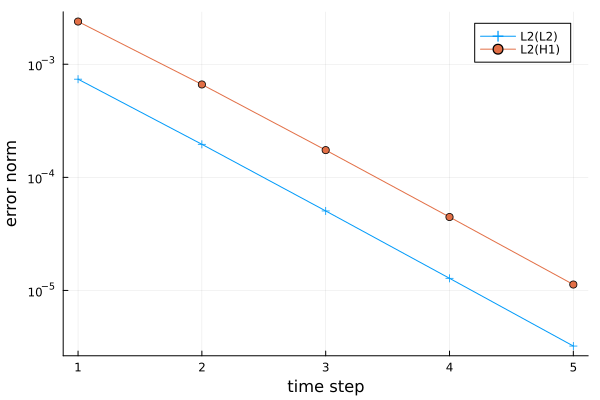

In [7]:
using Plots
println("L2: ", eL2)
println("H1: ", eH1)
taus = [ 1,2,3,4,5]
plot(taus,[eL2 eH1],
    yaxis=:log10,
    label=["L2(L2)" "L2(H1)"],
    shape=:auto,
    xlabel="time step",ylabel="error norm")